# Lab 6 - Intro to Image Classification with Convolutional Neural Networks


# Part A: Dataset

`Dataset Class`
-

In [ ]:
import torch
from torch.utils.data import Dataset
import random

class AddSaltPepperNoise(object):
    def __init__(self, prob=0.01):
        self.prob = prob  # Probability of a pixel being altered

    def __call__(self, tensor):
        # Create a copy of the tensor to modify
        output = tensor.clone()
        for i in range(tensor.size(1)):  # Iterate over each channel
            for j in range(tensor.size(2)):
                if random.random() < self.prob:
                    # Randomly set to either 0 (pepper) or 1 (salt)
                    output[:, i, j] = random.choice([0.0, 1.0])
        return output

    def __repr__(self):
        return f"{self.__class__.__name__}(prob={self.prob})"

class MyDataset(Dataset):
    def __init__(self, annotations_file, img_dir, is_train = False):
        import json
        import pandas as pd
        import torchvision.transforms as transforms
        super(MyDataset, self).__init__()

        with open(annotations_file) as f:
            data = json.load(f)

        self.img_labels = pd.DataFrame(
            [{"filename": k, "label": v} for k, v in data.items()]
        )

        self.img_dir = img_dir
        self.is_train = is_train
        self.crop_size = (256, 256)

        if self.is_train:
            self.transform = transforms.Compose([
                transforms.Resize((300, 300)),
                transforms.RandomCrop(self.crop_size),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                AddSaltPepperNoise(prob=0.1),  # Add salt-and-pepper noise
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.CenterCrop(self.crop_size),
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
            ])


    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        import os
        from PIL import Image

        path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(path).convert('RGB')
        image = self.transform(image)

        label = self.img_labels.iloc[idx, 1] - 1 # convert to 0 indexed
        label = torch.tensor(label)

        return image, label

`Test Dataset`
---

In [2]:
from torch.utils.data import DataLoader

training_dataset = MyDataset(annotations_file ="train_annos.json", img_dir = "cars_train")
loader = DataLoader(training_dataset,batch_size=1)

for im, label in loader:
      print(im.shape,label)

torch.Size([1, 3, 256, 256]) tensor([13])
torch.Size([1, 3, 256, 256]) tensor([2])
torch.Size([1, 3, 256, 256]) tensor([90])
torch.Size([1, 3, 256, 256]) tensor([133])
torch.Size([1, 3, 256, 256]) tensor([105])
torch.Size([1, 3, 256, 256]) tensor([122])
torch.Size([1, 3, 256, 256]) tensor([88])
torch.Size([1, 3, 256, 256]) tensor([95])
torch.Size([1, 3, 256, 256]) tensor([166])
torch.Size([1, 3, 256, 256]) tensor([57])
torch.Size([1, 3, 256, 256]) tensor([48])
torch.Size([1, 3, 256, 256]) tensor([185])
torch.Size([1, 3, 256, 256]) tensor([134])
torch.Size([1, 3, 256, 256]) tensor([84])
torch.Size([1, 3, 256, 256]) tensor([192])
torch.Size([1, 3, 256, 256]) tensor([171])
torch.Size([1, 3, 256, 256]) tensor([13])
torch.Size([1, 3, 256, 256]) tensor([72])
torch.Size([1, 3, 256, 256]) tensor([191])
torch.Size([1, 3, 256, 256]) tensor([56])
torch.Size([1, 3, 256, 256]) tensor([78])
torch.Size([1, 3, 256, 256]) tensor([35])
torch.Size([1, 3, 256, 256]) tensor([119])
torch.Size([1, 3, 256, 25

# Part B: Neural Network Architecture

`ResNet's Pretrained Network`
-

In [15]:
import torchvision

model = torchvision.models.resnet18(weights = torchvision.models.ResNet18_Weights.DEFAULT)

print(list(model.__dict__["_modules"].keys()))

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']


`ResNet layer`
-

In [4]:
print(model.fc)

Linear(in_features=512, out_features=1000, bias=True)


`ResNet Architecture Class`
-

In [5]:
import torch.nn as nn 

class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()

        ''' ResNet '''
        ref_model = torchvision.models.resnet18(weights = torchvision.models.ResNet18_Weights.DEFAULT)

        ''' batch norm '''
        self.bn1 = ref_model.bn1

        ''' convolution layers '''
        self.conv1 = ref_model.conv1

        ''' activation layers '''
        self.relu = ref_model.relu

        ''' pooling layers '''
        self.maxpool = ref_model.maxpool
        self.avgpool = ref_model.avgpool # global average pooling

        ''' residual layers '''
        self.layer1 = ref_model.layer1
        self.layer2 = ref_model.layer2
        self.layer3 = ref_model.layer3
        self.layer4 = ref_model.layer4

        ''' linear layers '''
        self.fc = nn.Linear(ref_model.fc.in_features, 196) # fully connected

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        
        x = self.fc(torch.flatten(x, 1))  # Pass through new fully connected layer
        return x

`Shape Test: (1, 196)`
-

In [6]:
import torch

model = MyNetwork()
test_im = torch.zeros((1,3,256,256))
output = model(test_im)

print(output.shape)

torch.Size([1, 196])


# Part C: Training

`Training Loop`
-

In [59]:
import torch
from tqdm import tqdm
import os

# grab data
training_dataset = MyDataset(annotations_file = "train_annos.json", img_dir = "cars_train", is_train = True)
train_loader = DataLoader(training_dataset, batch_size = 32, shuffle = True, num_workers = 4)

# model 
model = MyNetwork()
model = model.cuda()

# optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(params = model.parameters(), lr=learning_rate)

# loss function
loss_func = torch.nn.CrossEntropyLoss()

# training
num_epochs = 8
model.train() # training mode: neural network weights can change
losses = []
twenty = 20
save = 200
batch_count = 0


# files
plot_dir = 'plot_images'
checkpoint_dir = 'model_weight_checkpoints'
pth_file = 'model_weights'

for epoch in range(num_epochs):
    with tqdm(train_loader, unit = "batch") as timed_epoch:
        for images, labels in timed_epoch:
            timed_epoch.set_description(f"Epoch {epoch + 1}")

            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outs = model(images) # outs should have shape [batch_size, 196]

            loss = loss_func(outs, labels)  # loss_func would be an instance of a torch.nn.CrossEntropyLoss class
            loss.backward()
            optimizer.step()

            # track loss
            losses.append(loss.item())
            batch_count += 1

            # losses print for every 20 batches
            if batch_count % twenty == 0:
                avg_loss = sum(losses[-twenty:]) / twenty
                timed_epoch.set_postfix(loss = avg_loss)

            # Save model every 200 batches to avoid losing progress
            if batch_count % save == 0:
                os.makedirs(checkpoint_dir, exist_ok = True)
                torch.save(model.state_dict(), f"{checkpoint_dir}/{pth_file}_{batch_count}.pth")
                print(f"\t--Model checkpoint saved at step {batch_count}--")

Epoch 1:  79%|███████▉  | 202/255 [00:16<00:05, 10.14batch/s, loss=4.25]

	--Model checkpoint saved at step 200--


Epoch 2:  58%|█████▊    | 147/255 [00:13<00:10, 10.62batch/s, loss=3.02]

	--Model checkpoint saved at step 400--


Epoch 3:  35%|███▌      | 90/255 [00:08<00:16, 10.20batch/s, loss=2.12]

	--Model checkpoint saved at step 600--


Epoch 4:  13%|█▎        | 33/255 [00:00<00:19, 11.65batch/s, loss=1.4] 

	--Model checkpoint saved at step 800--


Epoch 4:  93%|█████████▎| 236/255 [00:19<00:01, 10.83batch/s, loss=1.22]

	--Model checkpoint saved at step 1000--


Epoch 5:  71%|███████   | 180/255 [00:14<00:03, 19.64batch/s, loss=0.806]

	--Model checkpoint saved at step 1200--


Epoch 6:  50%|████▉     | 127/255 [00:12<00:11, 11.15batch/s, loss=0.527]

	--Model checkpoint saved at step 1400--


Epoch 7:  28%|██▊       | 71/255 [00:07<00:17, 10.33batch/s, loss=0.355]

	--Model checkpoint saved at step 1600--


Epoch 8:   7%|▋         | 17/255 [00:02<00:24,  9.54batch/s, loss=0.315]

	--Model checkpoint saved at step 1800--


Epoch 8:  85%|████████▍ | 216/255 [00:17<00:03,  9.99batch/s, loss=0.239]

	--Model checkpoint saved at step 2000--


Epoch 8: 100%|██████████| 255/255 [00:20<00:00, 12.26batch/s, loss=0.255]


`Loss Plot`
-

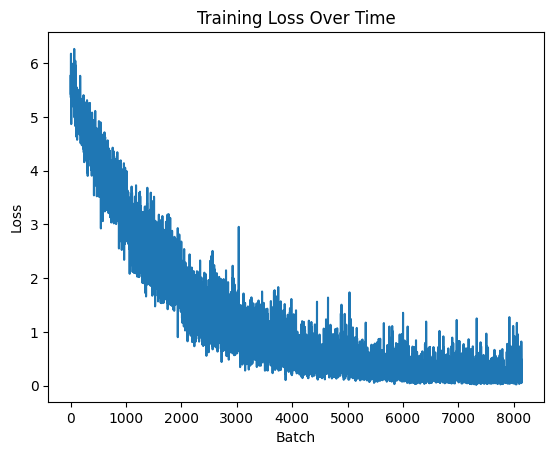

In [38]:
import matplotlib.pyplot as plt

# plot losses
plt.plot(losses)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
import os; os.makedirs(plot_dir, exist_ok = True)
plt.savefig(f"{plot_dir}/training_loss_plot.png")
plt.show()

# Part D: Testing

`Testing Loop`
---

In [60]:
import torch
from torch.utils.data import DataLoader

# grab data
test_dataset = MyDataset(annotations_file = "test_annos.json", img_dir = "cars_test")
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = True, num_workers = 4)

# evaluation mode
model.eval()
model = model.cuda()
all_predictions = []
all_labels = []

# test loop
with torch.no_grad():
    for images, labels in test_loader:
        # accelerate
        images, labels = images.cuda(), labels.cuda()
        
        # Get model predictions
        outputs = model(images)
        _, predicted = torch.max(input = outputs, dim = 1)
        
        # store predictions and ground truth labels
        all_predictions.extend(predicted.tolist())
        all_labels.extend(labels.tolist())


`Calculate Accuracy`
-

In [61]:
total_correct = sum([pred == true for pred, true in zip(all_predictions, all_labels)])
accuracy = total_correct / len(all_labels) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 81.15%


`Confusion Matrix`
-

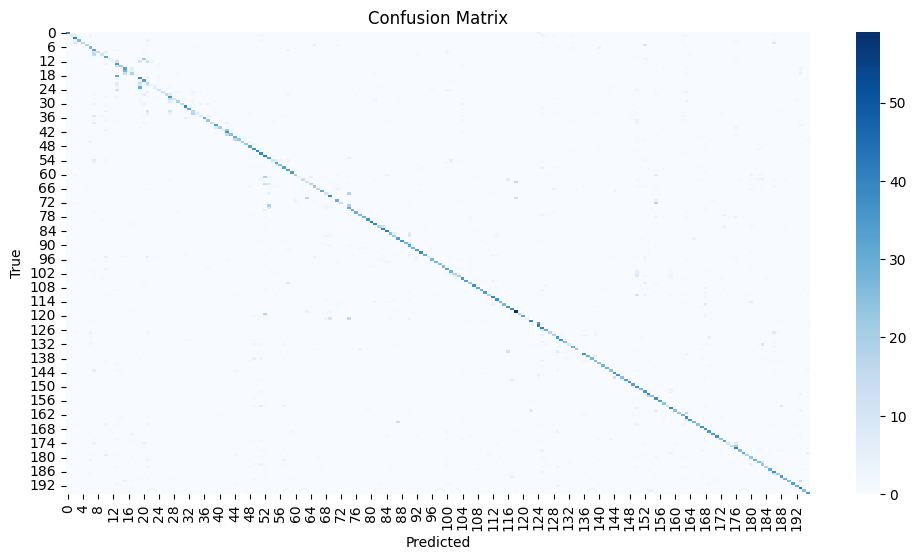

In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sea

c_matrix = confusion_matrix(y_true = all_labels, y_pred = all_predictions, labels = np.arange(stop = 196))
plt.figure(figsize = (12, 6))
sea.heatmap(data = c_matrix, annot = False, fmt = 'd', cmap = 'Blues')
plt.xlabel(xlabel = 'Predicted')
plt.ylabel(ylabel = 'True')
plt.title(label = 'Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

### Extra Credit Competition (5 pts)

An additional 5 pts of extra credit will be given to the individual with the highest test accuracy. You can try to improve the accuracy of your network using strategies such as data augmentation, learning rate schedulers, or different optimizers and batch sizes.

`Training Loop w/ Scheduler`
-

In [50]:
import torch
from tqdm import tqdm
import os

# grab data
training_dataset = MyDataset(annotations_file = "train_annos.json", img_dir = "cars_train", is_train = True)
train_loader = DataLoader(training_dataset, batch_size = 64, shuffle = True, num_workers = 4)

# model 
model = MyNetwork()
model = model.cuda()

# training
num_epochs = 20
model.train() # training mode: neural network weights can change
losses = []
twenty = 20
save = 200
batch_count = 0

# optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(params = model.parameters(), lr=learning_rate)

# scheduler
import torch.optim.lr_scheduler as lr_scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max = num_epochs)

# loss function
loss_func = torch.nn.CrossEntropyLoss()

# files
plot_dir = 'plot_images'
checkpoint_dir = 'model_weight_checkpoints'
pth_file = 'model_weights'

for epoch in range(num_epochs):
    with tqdm(train_loader, unit = "batch") as timed_epoch:
        for images, labels in timed_epoch:
            timed_epoch.set_description(f"Epoch {epoch + 1}")

            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outs = model(images) # outs should have shape [batch_size, 196]

            loss = loss_func(outs, labels)  # loss_func would be an instance of a torch.nn.CrossEntropyLoss class
            loss.backward()
            optimizer.step()
            

            # track loss
            losses.append(loss.item())
            batch_count += 1

            # losses print for every 20 batches
            if batch_count % twenty == 0:
                avg_loss = sum(losses[-twenty:]) / twenty
                timed_epoch.set_postfix(loss = avg_loss)

            # Save model every 200 batches to avoid losing progress
            if batch_count % save == 0:
                os.makedirs(checkpoint_dir, exist_ok = True)
                torch.save(model.state_dict(), f"{checkpoint_dir}/{pth_file}_{batch_count}.pth")
                print(f"\t--Model checkpoint saved at step {batch_count}--")

        scheduler.step()

Epoch 2:  57%|█████▋    | 73/128 [00:09<00:09,  5.81batch/s, loss=3.36]

	--Model checkpoint saved at step 200--


Epoch 4:  13%|█▎        | 17/128 [00:03<00:19,  5.75batch/s, loss=1.8]

	--Model checkpoint saved at step 400--


Epoch 5:  70%|██████▉   | 89/128 [00:11<00:06,  5.79batch/s, loss=1]   

	--Model checkpoint saved at step 600--


Epoch 7:  26%|██▌       | 33/128 [00:05<00:16,  5.78batch/s, loss=0.526]

	--Model checkpoint saved at step 800--


Epoch 8:  82%|████████▏ | 105/128 [00:14<00:04,  5.64batch/s, loss=0.346]

	--Model checkpoint saved at step 1000--


Epoch 10:  38%|███▊      | 49/128 [00:08<00:14,  5.64batch/s, loss=0.209]

	--Model checkpoint saved at step 1200--


Epoch 11:  95%|█████████▍| 121/128 [00:17<00:01,  5.67batch/s, loss=0.175]

	--Model checkpoint saved at step 1400--


Epoch 13:  51%|█████     | 65/128 [00:11<00:11,  5.63batch/s, loss=0.128]

	--Model checkpoint saved at step 1600--


Epoch 15:   7%|▋         | 9/128 [00:01<00:21,  5.45batch/s, loss=0.101]

	--Model checkpoint saved at step 1800--


Epoch 16:  63%|██████▎   | 81/128 [00:13<00:08,  5.65batch/s, loss=0.0875]

	--Model checkpoint saved at step 2000--


Epoch 18:  20%|█▉        | 25/128 [00:04<00:18,  5.72batch/s, loss=0.0823]

	--Model checkpoint saved at step 2200--


Epoch 19:  76%|███████▌  | 97/128 [00:16<00:05,  5.77batch/s, loss=0.0747]

	--Model checkpoint saved at step 2400--


Epoch 20: 100%|██████████| 128/128 [00:18<00:00,  7.03batch/s, loss=0.0797]


`Testing Scheduler`
-

In [52]:
import torch
from torch.utils.data import DataLoader

# grab data
test_dataset = MyDataset(annotations_file = "test_annos.json", img_dir = "cars_test")
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = True, num_workers = 4)

# evaluation mode
model.eval()
model = model.cuda()
all_predictions = []
all_labels = []

# test loop
with torch.no_grad():
    for images, labels in test_loader:
        # accelerate
        images, labels = images.cuda(), labels.cuda()
        
        # Get model predictions
        outputs = model(images)
        _, predicted = torch.max(input = outputs, dim = 1)
        
        # store predictions and ground truth labels
        all_predictions.extend(predicted.tolist())
        all_labels.extend(labels.tolist())


total_correct = sum([pred == true for pred, true in zip(all_predictions, all_labels)])
accuracy = total_correct / len(all_labels) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 85.36%


`Data Augmentation`
-

*The transform in my `Dataset` class has random cropping and random horizontal flips*

In [14]:
class MyDataset(Dataset):
    def __init__(self, annotations_file, img_dir, is_train = False):
        import json
        import pandas as pd
        import torchvision.transforms as transforms
        super(MyDataset, self).__init__()

        with open(annotations_file) as f:
            data = json.load(f)

        self.img_labels = pd.DataFrame(
            [{"filename": k, "label": v} for k, v in data.items()]
        )

        self.img_dir = img_dir
        self.is_train = is_train
        self.crop_size = (256, 256)
        
        if self.is_train:
            ######## DATA AUGMENTATION TRANSFORMATIONS ########
            self.transform = transforms.Compose([
                transforms.Resize((300, 300)),
                transforms.RandomCrop(self.crop_size),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.CenterCrop(self.crop_size),
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
            ])